<a href="https://colab.research.google.com/github/seolibek/Tufts2024/blob/main/tSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import seaborn as sns
from scipy.optimize import nnls
from skimage.feature import peak_local_max
import ipywidgets as widgets
from ipywidgets import interactive
from datetime import datetime
import sklearn
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive

/content/drive


In [5]:
cd MyDrive

/content/drive/MyDrive


In [6]:
ls

'Aryaman-draft- Casey Petersen.docx'
 Aryaman-Kaden-PeerReview.docx
"Aryaman's Peer Review of Yahya.gdoc"
'Aryaman Tepal - Beginning of Semester survey spring 2023.gdoc'
'Aryaman Tepal - Notes on your piece of media and research question (1).gdoc'
'Aryaman Tepal - Notes on your piece of media and research question (2).gdoc'
'Aryaman Tepal - Notes on your piece of media and research question.gdoc'
'AryamanTepal_resume (1).pdf'
'AryamanTepal_resume2 (1).pdf'
 AryamanTepal_resume2.pdf
'AryamanTepal_resume (2).pdf'
'AryamanTepal_resume (3).pdf'
'AryamanTepal_resume (4).pdf'
 AryamanTepal_resume.pdf
'Aryaman Tepal Resume.pdf'
'Aryaman_Tepal Resume.pdf'
'Aryaman Tepal Schedule.png'
'Aryaman Tepal Transcript.pdf'
'Aryaman_Tepal Transcript.pdf'
'Blade Runner 2049 - A Human Touch.docx'
'Chem - Poster Content.gdoc'
 Classroom/
'Colab Notebooks'/
'Copy of Ace the Coding Interview ATCI Guide.gdoc'
'Copy of Lab03: Lists (Questionnaire).gdoc'
'Copy of Lab04: Branching (Questionnaire).gdoc'
'Copy of 

Loading in the HSI Data

In [7]:
#read in the data
import numpy as np
import scipy.io

def loadHSI(data_path, ground_truth_path, data_col, ground_truth_col):
  data = scipy.io.loadmat(data_path)
  HSI = data[data_col]

  data = scipy.io.loadmat(ground_truth_path)
  GT = data[ground_truth_col]

  M, N, D = HSI.shape
  n = M * N
  X = HSI.reshape((n, D))
  X = X.astype(np.float64)

  norms = np.sqrt(np.sum(X**2, axis = 0))
  X /= norms

  X += 1e-6 * np.random.randn(*X.shape)

  HSI = X.reshape((M, N, D))

  new_gt = np.zeros_like(GT)
  unique_classes = np.unique(GT)
  K = len(unique_classes)

  for k, uc in enumerate(unique_classes, start=1):
      new_gt[GT == uc] = k
  n = new_gt.size
  Y = new_gt.reshape((n, 1))
  GT = new_gt

  return X, M, N, D, HSI, GT, Y, n, K

In [8]:
salinasA_path = '/content/drive/MyDrive/SalinasA_corrected.mat'
salinasA_gt_path = '/content/drive/MyDrive/SalinasA_gt.mat'

X, M, N, D, HSI, GT, Y, n, K = loadHSI(salinasA_path, salinasA_gt_path, 'salinasA_corrected', 'salinasA_gt')

In [9]:
print(HSI.shape)
print(GT.shape)

(83, 86, 204)
(83, 86)


In [10]:
# def umap_projection_2d(hsi_data):

#   data_reshaped = hsi_data.reshape(-1, hsi_data.shape[2])

#   #setting seed so i dont get a bunch of diff results. not random rn
#   reducer = umap.UMAP(random_state=42)
#   embedding = reducer.fit_transform(data_reshaped)

#   # Visualization
#   plt.figure(figsize=(10, 8))
#   plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1, cmap='Spectral')
#   plt.title('2D UMAP Projection of the Dataset')
#   plt.colorbar(label='Spectral classes')
#   plt.show()

def tsne_projection_2d(hsi_data, ground_truth, perplexity=30, random_state=42):
  # Reshape the data to (n_samples, n_features)
  data_reshaped = hsi_data.reshape(-1, hsi_data.shape[2])

  # Initialize and fit t-SNE
  tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', init='random', random_state=random_state)
  embedding = tsne.fit_transform(data_reshaped)

  # Visualization
  plt.figure(figsize=(10, 8))
  scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=ground_truth.ravel(), s=0.1, cmap='Spectral')
  plt.title('2D t-SNE Projection of the Dataset')
  plt.colorbar(scatter, label='Spectral classes')
  plt.xlabel('t-SNE 1')
  plt.ylabel('t-SNE 2')
  plt.show()

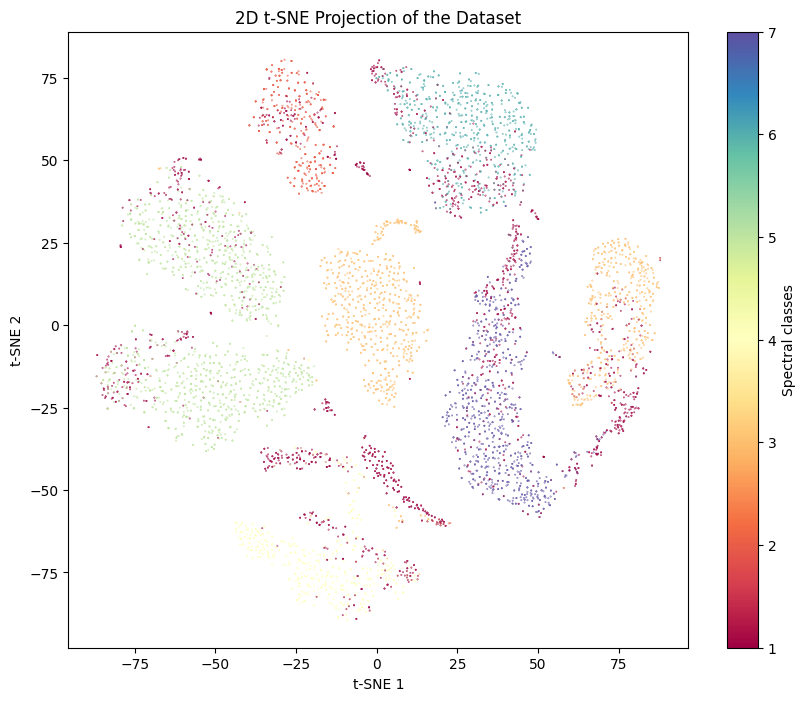

In [11]:
tsne_projection_2d(HSI, GT)

In [17]:
def show_clusterable_embedding(hsi_data, ground_truth):

# Reshape the data to (n_samples, n_features)
  data_reshaped = hsi_data.reshape(-1, hsi_data.shape[2])

  # Apply t-SNE to reduce dimensionality to 2D
  tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='random', random_state=42)
  clusterable_embedding = tsne.fit_transform(data_reshaped)

  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
              c=ground_truth, s=0.1, cmap='Spectral');

  return clusterable_embedding, data_reshaped

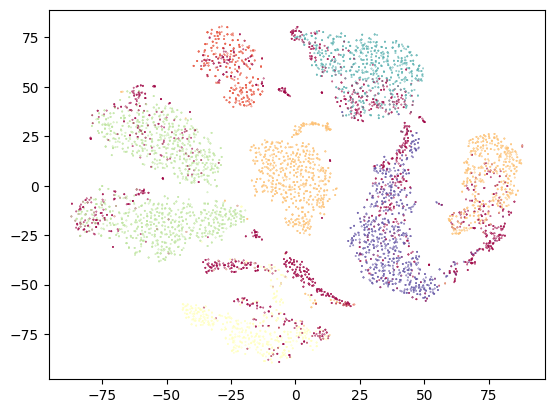

In [18]:
clust_emb, reshaped_hsi = show_clusterable_embedding(HSI, GT)

In [19]:
#Adjusting just salinas A for the label 0 difference, but not adjusting any of the other datasets and then we graph
#Technically did this above but we show this with the proper labels!

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def two_d_mapping_labeled(ground_truth, clusterable_embedding, dataset_name, is_salinasA=False):
    n_classes = np.max(ground_truth) + 1
    spectral_cmap = plt.cm.get_cmap('Spectral', n_classes)

    if is_salinasA:
        colors = spectral_cmap(np.linspace(0, 1, n_classes))
        colors[0] = [0, 0, 0, 1]  # (class 0) to black
    else:
        colors = spectral_cmap(np.linspace(0, 1, n_classes))

    new_camp = ListedColormap(colors)

    plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
                c=ground_truth, s=0.1, cmap=new_camp)
    plt.colorbar(ticks=np.arange(n_classes))
    plt.title(f'2D mapping of {dataset_name}, {"including class 0" if not is_salinasA else "excluding class 0"}', fontsize=18)
    plt.show()

<ipython-input-19-4dac8f5aa35d>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  spectral_cmap = plt.cm.get_cmap('Spectral', n_classes)


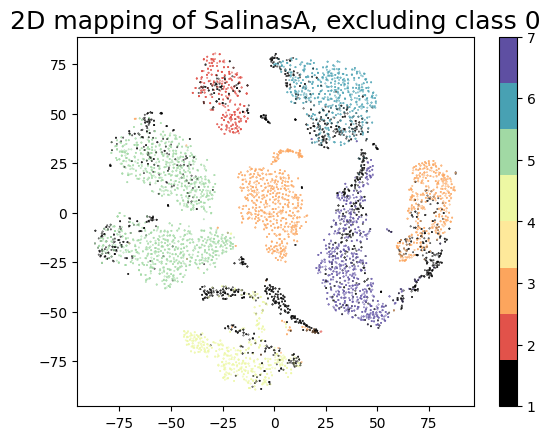

In [20]:
two_d_mapping_labeled(GT,clust_emb, dataset_name = 'SalinasA',  is_salinasA = True)

In [21]:
!pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=c6e87b8d2c82fcb7f43855652747d0f4be7c6667d2f9fad8197b7881e33a56a4
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


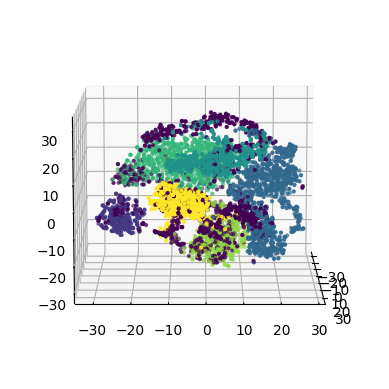

In [52]:
from matplotlib.animation import FuncAnimation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
tsne = TSNE(n_components=3, perplexity=30, learning_rate='auto', init='random', random_state=42)
u = tsne.fit_transform(reshaped_hsi)
ax.scatter(u[:,0], u[:,1], u[:,2], c=GT, s=4)
title = ''
plt.title(title, fontsize=18)
def update(frame):
    ax.view_init(elev=10, azim=frame)
    return fig,
ani = FuncAnimation(fig, update, frames=range(0, 360, 2), blit=True)

plt.show()
ani.save(f'tsne_rotation_SalinasA.mp4', writer='ffmpeg', fps=30)

In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def k_means_with_tsne(dim_reduced_data, ground_truth):

    GT_flat = ground_truth.flatten()
    num_clusters = len(np.unique(GT_flat))

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(dim_reduced_data)

    # Calculate Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(GT_flat, labels)
    print("t-SNE Adjusted Rand Index (ARI):", ari)

    return GT_flat, labels

In [53]:
gt_tsne_3, labels_tsne_3 = k_means_with_tsne(u,GT)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


t-SNE Adjusted Rand Index (ARI): 0.3554041461209524


In [54]:
from sklearn.decomposition import PCA

def kmeans_with_pca(data,n_components, ground_truth):
  GT_flat_PCA = ground_truth.flatten()

  pca = PCA(n_components)
  data_reduced = pca.fit_transform(data)

  num_clusters = len(np.unique(GT_flat_PCA))
  # - (1 if 0 in GT_flat_PCA else 0)
  kmeans = KMeans(n_clusters=num_clusters, random_state=42)
  labels = kmeans.fit_predict(data_reduced)

  # Calculate Adjusted Rand Index (ARI)
  ari = adjusted_rand_score(GT_flat_PCA, labels)
  print("PCA Adjusted Rand Index (ARI):", ari)
  return GT_flat_PCA, labels

In [55]:
gt_flat_pca_3, labels_pca_3 = kmeans_with_pca(reshaped_hsi,3, GT)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA Adjusted Rand Index (ARI): 0.3791122936600893


In [56]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def calculate_aligned_accuracy(true_labels, cluster_labels):
    cm = confusion_matrix(true_labels, cluster_labels)

    row_ind, col_ind = linear_sum_assignment(-cm)
    label_mapping = {cluster_label: true_label for cluster_label, true_label in zip(col_ind, row_ind)}
    aligned_labels = [label_mapping[label] for label in cluster_labels]

    accuracy = np.mean(np.array(aligned_labels) == np.array(true_labels))

    return accuracy

In [58]:
print("TSNE:", calculate_aligned_accuracy(gt_tsne_3, labels_tsne_3))
print("PCA:", calculate_aligned_accuracy(gt_flat_pca_3, labels_pca_3))

TSNE: 0.5612216307088821
PCA: 0.5623423928271224
